In [1]:
import numpy as np 
import pandas as pd
import matplotlib as mpl
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn import model_selection,linear_model, metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
import xgboost as xgb
from joblib import dump
from joblib import load

In [2]:
cr_loan = pd.read_csv("./data/credit_risk_dataset.csv")

# Explore the credit data

#### In this data set, loan_status shows whether the loan is currently in default or not with 1 being default and 0 being non-default.

In [3]:
cr_loan.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


### Renaming some columns

In [4]:
cr_loan = cr_loan.rename(columns = {"cb_person_default_on_file":"default_hist", "cb_person_cred_hist_length": "cr_hist_len"})

In [5]:
cr_loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   person_age             32581 non-null  int64  
 1   person_income          32581 non-null  int64  
 2   person_home_ownership  32581 non-null  object 
 3   person_emp_length      31686 non-null  float64
 4   loan_intent            32581 non-null  object 
 5   loan_grade             32581 non-null  object 
 6   loan_amnt              32581 non-null  int64  
 7   loan_int_rate          29465 non-null  float64
 8   loan_status            32581 non-null  int64  
 9   loan_percent_income    32581 non-null  float64
 10  default_hist           32581 non-null  object 
 11  cr_hist_len            32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [6]:
print(pd.crosstab(cr_loan["loan_intent"], cr_loan["loan_status"], margins = True))

loan_status            0     1    All
loan_intent                          
DEBTCONSOLIDATION   3722  1490   5212
EDUCATION           5342  1111   6453
HOMEIMPROVEMENT     2664   941   3605
MEDICAL             4450  1621   6071
PERSONAL            4423  1098   5521
VENTURE             4872   847   5719
All                25473  7108  32581


In [7]:
print(pd.crosstab(cr_loan["person_home_ownership"], cr_loan["loan_status"],
              values=cr_loan["loan_percent_income"], aggfunc="mean"))

loan_status                   0         1
person_home_ownership                    
MORTGAGE               0.146504  0.184882
OTHER                  0.143784  0.300000
OWN                    0.180013  0.297358
RENT                   0.144611  0.264859


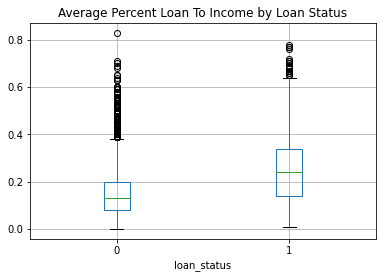

In [8]:
cr_loan.boxplot(column = ["loan_percent_income"], by = "loan_status")
plt.title('Average Percent Loan To Income by Loan Status')
plt.suptitle('')
plt.show()

### In average the defaulters have a higher loan income percentage

In [9]:
cr_loan.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cr_hist_len
count,32581.000000,3.258100e+04,31686.000000,32581.000000,29465.000000,32581.000000,32581.000000,32581.000000
mean,27.734600,6.607485e+04,4.789686,9589.371106,11.011695,0.218164,0.170203,5.804211
std,6.348078,6.198312e+04,4.142630,6322.086646,3.240459,0.413006,0.106782,4.055001
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.470000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


### With the describe method I can already see that the data has a few columns that contain outliers. 

- person_emp_length contains a max of 123 years
- person_income contains a max of 6.000.000 $
- person_age contains a max of 144 years 

I will further discover this outliers in the later steps and eliminate them.

In [10]:
#Scatterplot matrix
fig = px.scatter_matrix(cr_loan, dimensions=["person_age","person_income","person_emp_length","loan_amnt","loan_int_rate", "cr_hist_len"],labels={col:col.replace('_', ' ') for col in cr_loan.columns}, height=900, width=900, color="loan_status", color_continuous_scale=px.colors.diverging.Tealrose)
fig.show()

# Exploring and handling NaN values

Index(['person_emp_length', 'loan_int_rate'], dtype='object')
895
     person_age  person_income person_home_ownership  person_emp_length  \
105          22          12600              MORTGAGE                NaN   
222          24         185000              MORTGAGE                NaN   
379          24          16800              MORTGAGE                NaN   
407          25          52000                  RENT                NaN   
408          22          17352              MORTGAGE                NaN   

           loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
105           PERSONAL          A       2000           5.42            1   
222          EDUCATION          B      35000          12.42            0   
379  DEBTCONSOLIDATION          A       3900            NaN            1   
407           PERSONAL          B      24000          10.74            1   
408          EDUCATION          C       2250          15.27            0   

     loan_percent_income c

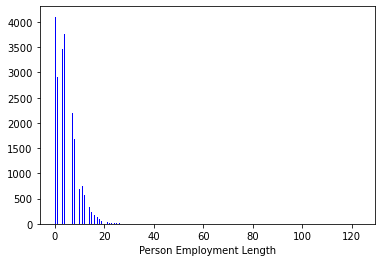

In [8]:
# Print a null value column array
print(cr_loan.columns[cr_loan.isnull().any()])

# print the number of nulls in person_emp_lenght
print(cr_loan["person_emp_length"].isnull().sum())

# Print the top five rows with nulls for employment length
print(cr_loan[cr_loan["person_emp_length"].isnull()].head())

# Impute the null values with the median value for all employment lengths
cr_loan["person_emp_length"].fillna((cr_loan['person_emp_length'].median()), inplace=True)

# Create a histogram of employment length
n, bins, patches = plt.hist(cr_loan["person_emp_length"], bins='auto', color='blue')
plt.xlabel("Person Employment Length")
plt.show()

In [12]:
# Print the number of nulls
print(cr_loan["loan_int_rate"].isnull().sum())

# Store the array on indices
indices = cr_loan[cr_loan["loan_int_rate"].isnull()].index

# Save the new data without missing data
cr_loan = cr_loan.drop(indices)

3116


In [13]:
### There were about 3000 rows with null values in the loan_int_rate column.

# Eliminating Outliers

### Visualy inspect the outliers

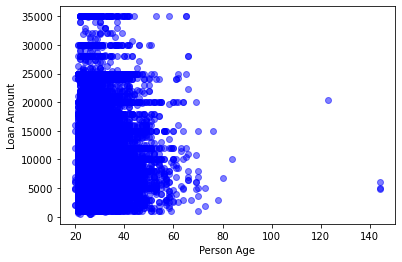

In [14]:
plt.scatter(cr_loan["person_age"], cr_loan["loan_amnt"], c='blue', alpha=0.5)
plt.xlabel("Person Age")
plt.ylabel("Loan Amount")
plt.show()

#### -> It is clearly visable that there are some rows with over 100 years in the age column

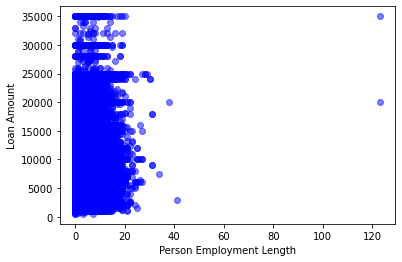

In [15]:
plt.scatter(cr_loan["person_emp_length"], cr_loan["loan_amnt"], c='blue', alpha=0.5)
plt.xlabel("Person Employment Length")
plt.ylabel("Loan Amount")
plt.show()

#### -> It is clearly visable that there are some rows with over 120 years in the employment lenght column.

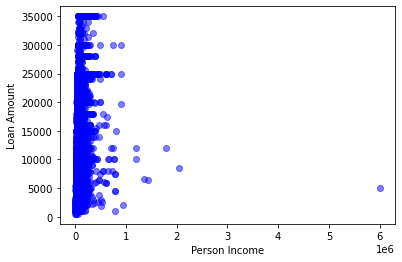

There is 1 row with more than 2.5 million $ income.


In [16]:
plt.scatter(cr_loan["person_income"], cr_loan["loan_amnt"], c='blue', alpha=0.5)
plt.xlabel("Person Income")
plt.ylabel("Loan Amount")
plt.show()

print("There is {} row with more than 2.5 million $ income.".format(len(cr_loan[cr_loan["person_income"] > 2500000])))

### Eliminating the outliers by only selecting rows with values under a certain threshold in age and employment length

In [17]:
cr_loan= cr_loan[cr_loan['person_age']<=100]
cr_loan = cr_loan[cr_loan['person_emp_length']<=100]

#### From the observation of the scatter matrix in plotly I was able to see that the row with 6 million $ income also had 144 years in the age column. This row was also erased by the code above.

In [18]:
cr_loan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29459 entries, 1 to 32580
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   person_age             29459 non-null  int64  
 1   person_income          29459 non-null  int64  
 2   person_home_ownership  29459 non-null  object 
 3   person_emp_length      29459 non-null  float64
 4   loan_intent            29459 non-null  object 
 5   loan_grade             29459 non-null  object 
 6   loan_amnt              29459 non-null  int64  
 7   loan_int_rate          29459 non-null  float64
 8   loan_status            29459 non-null  int64  
 9   loan_percent_income    29459 non-null  float64
 10  default_hist           29459 non-null  object 
 11  cr_hist_len            29459 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 2.9+ MB


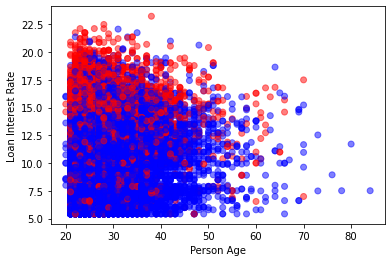

In [19]:
# Create a scatter plot of age and interest rate
colors = ["blue","red"]
plt.scatter(cr_loan["person_age"],cr_loan["loan_int_rate"],
            c = cr_loan['loan_status'],
            cmap = mpl.colors.ListedColormap(colors),
            alpha=0.5)
plt.xlabel("Person Age")
plt.ylabel("Loan Interest Rate")
plt.show()

### The plot clearly shows that there are more defaults with high interest rates (red color).

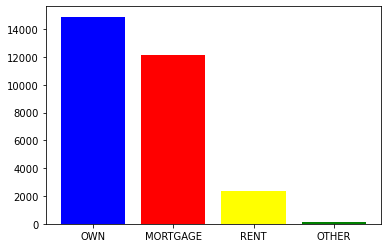

In [20]:
colors = ["blue","red", "yellow", "green"]
height = list(cr_loan["person_home_ownership"].value_counts())
bars = tuple(cr_loan["person_home_ownership"].unique())
x_pos = np.arange(len(bars))

# Create bars with different colors
plt.bar(x_pos, height, color=colors)

# Create names on the x-axis
plt.xticks(x_pos, bars)

# Show graph
plt.show()

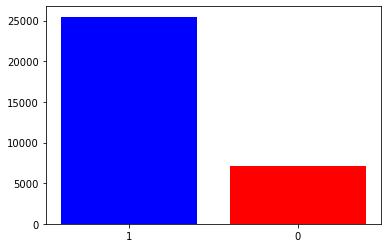

In [9]:
colors = ["blue","red"]
height = list(cr_loan["loan_status"].value_counts())
bars = tuple(cr_loan["loan_status"].unique())
x_pos = np.arange(len(bars))

# Create bars with different colors
plt.bar(x_pos, height, color=colors)

# Create names on the x-axis
plt.xticks(x_pos, bars)

# Show graph
plt.show()

# Preparing the data for training

In [21]:
# the loan_grade includes data that a user of the tool that I want to build in this capstone is mostly not knowing himself, so I am going to delete this column. I ran some tests with an XGBoost including the loan_grade column and the feature importance showed that the loan_grade is not of greate importance for the performance of the model. 

In [22]:
cr_loan_clean = cr_loan.drop(["loan_grade"], axis=1)

In [23]:
cr_loan_clean

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_amnt,loan_int_rate,loan_status,loan_percent_income,default_hist,cr_hist_len
1,21,9600,OWN,5.0,EDUCATION,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,35000,14.27,1,0.55,Y,4
5,21,9900,OWN,2.0,VENTURE,2500,7.14,1,0.25,N,2
...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,MORTGAGE,1.0,PERSONAL,5800,13.16,0,0.11,N,30
32577,54,120000,MORTGAGE,4.0,PERSONAL,17625,7.49,0,0.15,N,19
32578,65,76000,RENT,3.0,HOMEIMPROVEMENT,35000,10.99,1,0.46,N,28
32579,56,150000,MORTGAGE,5.0,PERSONAL,15000,11.48,0,0.10,N,26


In [24]:
# one hot encoding categorical variables
num_col = cr_loan_clean.select_dtypes(exclude = 'object')
char_col = cr_loan_clean.select_dtypes(include = 'object')

encoded_char_col = pd.get_dummies(char_col)

cr_encoded = pd.concat([num_col, encoded_char_col], axis=1)
cr_encoded

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cr_hist_len,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_DEBTCONSOLIDATION,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,default_hist_N,default_hist_Y
1,21,9600,5.0,1000,11.14,0,0.10,2,0,0,1,0,0,1,0,0,0,0,1,0
2,25,9600,1.0,5500,12.87,1,0.57,3,1,0,0,0,0,0,0,1,0,0,1,0
3,23,65500,4.0,35000,15.23,1,0.53,2,0,0,0,1,0,0,0,1,0,0,1,0
4,24,54400,8.0,35000,14.27,1,0.55,4,0,0,0,1,0,0,0,1,0,0,0,1
5,21,9900,2.0,2500,7.14,1,0.25,2,0,0,1,0,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,1.0,5800,13.16,0,0.11,30,1,0,0,0,0,0,0,0,1,0,1,0
32577,54,120000,4.0,17625,7.49,0,0.15,19,1,0,0,0,0,0,0,0,1,0,1,0
32578,65,76000,3.0,35000,10.99,1,0.46,28,0,0,0,1,0,0,1,0,0,0,1,0
32579,56,150000,5.0,15000,11.48,0,0.10,26,1,0,0,0,0,0,0,0,1,0,1,0


In [25]:
loan_status = cr_encoded["loan_status"].value_counts()

In [26]:
print("There are {} non-defaulting rows and {} defaulting rows in the data, resulting in imbalanced data ratio of {} .".format(loan_status[0], loan_status[1], round(loan_status[0]/loan_status[1], 2)))

There are 22996 non-defaulting rows and 6463 defaulting rows in the data, resulting in imbalanced data ratio of 3.56 .


In [27]:
cr_encoded.to_csv("./data/cr_encoded.csv")

#### To split the data in train and test data and have the same distribution of non-defaulting and defaulting rows in both I used the stratify parameter in the sklearn train_test_split function.

In [28]:
# Split Train and Test Sets
Y = cr_encoded['loan_status']
X = cr_encoded.drop('loan_status',axis=1)
 
x_train, x_test, y_train, y_test = model_selection.train_test_split(X, Y, stratify=Y, random_state=2020, test_size=.30)

In [29]:
cr_encoded

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cr_hist_len,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_DEBTCONSOLIDATION,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,default_hist_N,default_hist_Y
1,21,9600,5.0,1000,11.14,0,0.10,2,0,0,1,0,0,1,0,0,0,0,1,0
2,25,9600,1.0,5500,12.87,1,0.57,3,1,0,0,0,0,0,0,1,0,0,1,0
3,23,65500,4.0,35000,15.23,1,0.53,2,0,0,0,1,0,0,0,1,0,0,1,0
4,24,54400,8.0,35000,14.27,1,0.55,4,0,0,0,1,0,0,0,1,0,0,0,1
5,21,9900,2.0,2500,7.14,1,0.25,2,0,0,1,0,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,1.0,5800,13.16,0,0.11,30,1,0,0,0,0,0,0,0,1,0,1,0
32577,54,120000,4.0,17625,7.49,0,0.15,19,1,0,0,0,0,0,0,0,1,0,1,0
32578,65,76000,3.0,35000,10.99,1,0.46,28,0,0,0,1,0,0,1,0,0,0,1,0
32579,56,150000,5.0,15000,11.48,0,0.10,26,1,0,0,0,0,0,0,0,1,0,1,0


In [30]:
X.to_csv("./data/X.csv")
Y.to_csv("./data/Y.csv")
x_train.to_csv("./data/x_train.csv")
x_test.to_csv("./data/x_test.csv")
y_train.to_csv("./data/y_train.csv")
y_test.to_csv("./data/y_test.csv")